# FinBERT Evaluation

We now test a transformer-based model [`ProsusAI/finbert`](https://huggingface.co/ProsusAI/finbert) which was pre-trained on financial sentiment tasks on top of the BERT language model.

**Note:** Since FinBERT was trained on Financial PhraseBank (FPB), we exclude FPB to avoid data leakage.


In [ ]:
import sys

sys.path.append("../scripts")

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from metrics import per_source_metrics
from plot_utils import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import pipeline

## Load Twitter + FiQA Validation Data


In [8]:
val_df = pd.read_csv("../data/processed/val.csv")

no_fpb_val = val_df[val_df["source"] != "FPB"]

print("Validation size (excluding FPB):", no_fpb_val.shape[0], "\n")
print(no_fpb_val["source"].value_counts())

Validation size (excluding FPB): 1308 

source
Twitter    1197
FiQA        111
Name: count, dtype: int64


## Run FinBERT Inference


In [10]:
sentiment_pipe = pipeline("text-classification", model="ProsusAI/finbert")

val_texts = no_fpb_val["sentence"].tolist()
results = sentiment_pipe(val_texts, truncation=True)
finbert_labels = [r["label"].lower() for r in results]

print("Sample predictions:", finbert_labels[:5])

Device set to use cpu


Sample predictions: ['neutral', 'neutral', 'neutral', 'negative', 'negative']


## Evaluation


### Per-Source Evaluation


In [12]:
finbert_results = per_source_metrics(
    no_fpb_val["label"], finbert_labels, no_fpb_val["source"]
)

print("FinBERT Per-Source Performance:\n")
for source, acc, f1 in finbert_results:
    print(f"{source}: Accuracy={acc:.3f}, Macro-F1={f1:.3f}")

FinBERT Per-Source Performance:

Twitter: Accuracy=0.706, Macro-F1=0.646
FiQA: Accuracy=0.405, Macro-F1=0.397


### Classification Report


In [14]:
print("Full Report:\n")
print(classification_report(no_fpb_val["label"], finbert_labels))

Full Report:

              precision    recall  f1-score   support

    negative       0.50      0.72      0.59       213
     neutral       0.78      0.75      0.76       780
    positive       0.61      0.49      0.54       315

    accuracy                           0.68      1308
   macro avg       0.63      0.65      0.63      1308
weighted avg       0.69      0.68      0.68      1308



### Confusion Matrix


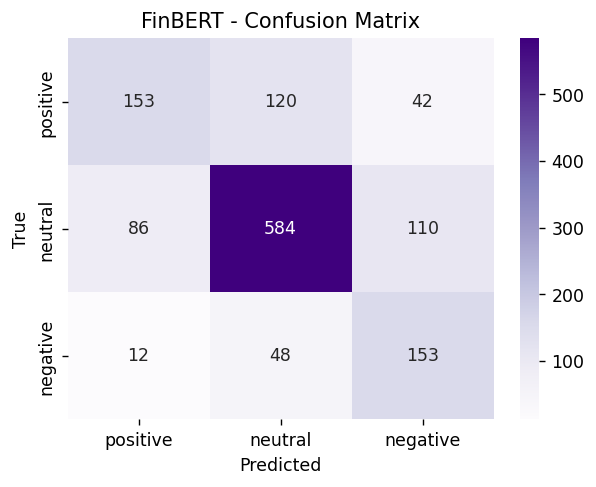

In [60]:
plot_confusion_matrix(
    y_true=no_fpb_val["label"],
    y_pred=finbert_labels,
    labels=["positive", "neutral", "negative"],
    title="FinBERT - Confusion Matrix",
    cmap="Purples",
)

## Save Predictions & Report


In [ ]:
pd.DataFrame(
    classification_report(no_fpb_val["label"], finbert_labels, output_dict=True)
).transpose().to_csv("../models/finbert/finbert-preds.csv")

with open("../models/finbert/finbert-preds.txt", "w") as f:
    for item in finbert_labels:
        f.write(item + "\n")

## Summary

-   Evaluated FinBERT on real-world financial text (Twitter + FiQA)
-   Achieved strong results, especially on Twitter
-   Confusion matrix shows areas for improvement (e.g., neutral &harr; negative)

Next: We'll compare this to rule-based and generative LLM methods in **[4_spacy_textblob.ipynb](4_spacy_textblob.ipynb)**.
